In [3]:
import os
import sys
import onnx
import numpy as np
import pickle as pkl
import onnxruntime as ort
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [4]:
sys.path.append("../src/")

from preprocessing_utils import normalize, centroid, to_polar, to_cart

# Sample Data

Text(0.5, 1.0, 'slice-456.npy')

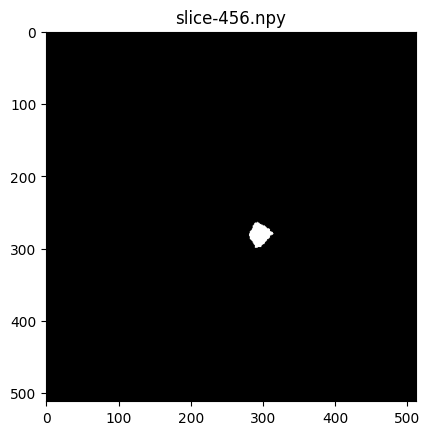

In [5]:
VOLUME_NO = 2
ROOT_SAMPLES_PATH = f"../../../unet-lits-2d-pipeline/LOADDATA/Training_Data_2D/Volumes/volume-{VOLUME_NO}/"
ROOT_MASKS_PATH = f"../../../unet-lits-2d-pipeline/LOADDATA/Training_Data_2D/LesionMasks/volume-{VOLUME_NO}/"

# Find a slice with marked lesion

for slice_name in os.listdir(ROOT_MASKS_PATH):
    slice_mask = np.load(os.path.join(ROOT_MASKS_PATH, slice_name))
    if np.sum(slice_mask) > 100:
        valid_mask_name = slice_name
        valid_mask_data = slice_mask.copy()
        break

plt.imshow(valid_mask_data, cmap="gray")
plt.title(valid_mask_name)

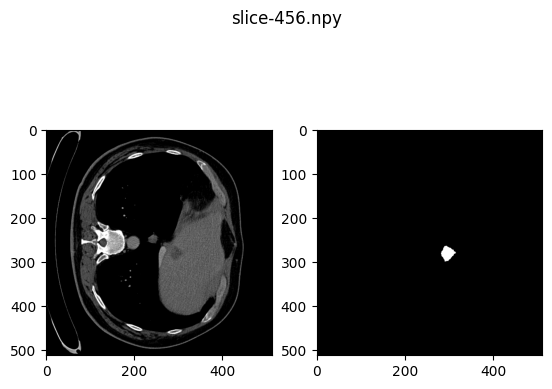

In [6]:
valid_sample_slice = np.load(os.path.join(ROOT_SAMPLES_PATH, valid_mask_name))
postprocessed_slice = normalize(valid_sample_slice, zero_center=False, unit_variance=False)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(postprocessed_slice, cmap="gray")
axs[1].imshow(valid_mask_data, cmap="gray")

_ = fig.suptitle(valid_mask_name)


# Carthesian Inference Session

In [7]:
EXPERIMENT_PATH = "../experiments_data/set_3/lesion/experiment_7/"
CONFIG_NAME = "experiment_config.pkl"
MODEL_NAME = "best_val_dice.onnx"

with open(os.path.join(EXPERIMENT_PATH, CONFIG_NAME), "rb") as f:
    experiment_config = pkl.load(f)
pprint(experiment_config)

carthesian_model = onnx.load(os.path.join(EXPERIMENT_PATH, MODEL_NAME))
onnx.checker.check_model(carthesian_model)

carthesian_inference_session = ort.InferenceSession(os.path.join(EXPERIMENT_PATH, MODEL_NAME))

{'device': 'cuda',
 'model_config': {'backbone': 'base',
                  'block_type': 'base',
                  'channels': 1,
                  'dilation': [1, 1, 1, 1, 1],
                  'dilation_up': [1, 1, 1, 1, 1],
                  'dropout': 0,
                  'filter_sizes': [20, 40, 80, 160, 320, 640],
                  'filter_sizes_up': [20, 40, 80, 160, 320, 640],
                  'filter_start': 20,
                  'filter_start_up': 20,
                  'init_type': 'he_n',
                  'model': 'classic_unet',
                  'model_name': 'vUnet2D',
                  'se_reduction': 0,
                  'structure': [3, 3, 3, 3, 3],
                  'structure_up': [3, 3, 3, 3, 3],
                  'up_conv_type': [4, 2, 1],
                  'use_auxiliary_inputs': False,
                  'use_batchnorm': True,
                  'use_conv_pool': True,
                  'use_pypool': False},
 'training_config': {'Training_ROI_Vicinity': 4,
       

## Predict

In [8]:
carthesian_input = np.expand_dims(np.expand_dims(postprocessed_slice, 0), 0).astype(np.float32)
carthesian_out = carthesian_inference_session.run(None, {"input": carthesian_input})[0]
carthesian_model_prediction = np.argmax(carthesian_out, axis=1)[0]
print(carthesian_model_prediction.shape)
print(np.unique(carthesian_model_prediction))

(512, 512)
[0 1]


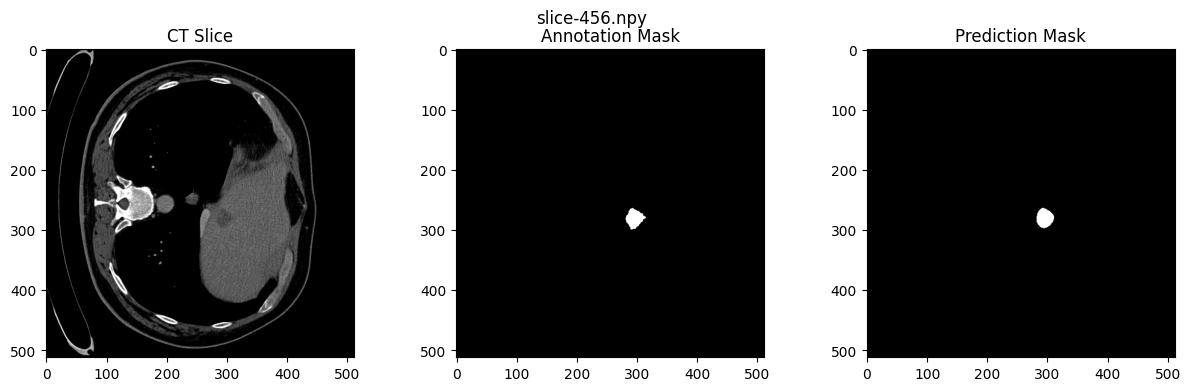

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].imshow(postprocessed_slice, cmap="gray")
axs[0].set_title("CT Slice")
axs[1].imshow(valid_mask_data, cmap="gray")
axs[1].set_title("Annotation Mask")
axs[2].imshow(carthesian_model_prediction, cmap="gray")
axs[2].set_title("Prediction Mask")

_ = fig.suptitle(valid_mask_name)

# Polar Inference Session

In [10]:
EXPERIMENT_PATH = "../experiments_data/set_3/lesion/experiment_6/"

with open(os.path.join(EXPERIMENT_PATH, CONFIG_NAME), "rb") as f:
    experiment_config = pkl.load(f)
pprint(experiment_config)

polar_model = onnx.load(os.path.join(EXPERIMENT_PATH, MODEL_NAME))
onnx.checker.check_model(polar_model)

polar_inference_session = ort.InferenceSession(os.path.join(EXPERIMENT_PATH, MODEL_NAME))

{'device': 'cuda',
 'model_config': {'backbone': 'base',
                  'block_type': 'base',
                  'channels': 1,
                  'dilation': [1, 1, 1, 1, 1],
                  'dilation_up': [1, 1, 1, 1, 1],
                  'dropout': 0,
                  'filter_sizes': [20, 40, 80, 160, 320, 640],
                  'filter_sizes_up': [20, 40, 80, 160, 320, 640],
                  'filter_start': 20,
                  'filter_start_up': 20,
                  'init_type': 'he_n',
                  'model': 'classic_unet',
                  'model_name': 'vUnet2D',
                  'se_reduction': 0,
                  'structure': [3, 3, 3, 3, 3],
                  'structure_up': [3, 3, 3, 3, 3],
                  'up_conv_type': [4, 2, 1],
                  'use_auxiliary_inputs': False,
                  'use_batchnorm': True,
                  'use_conv_pool': True,
                  'use_pypool': False},
 'training_config': {'Training_ROI_Vicinity': 4,
       

## Predict

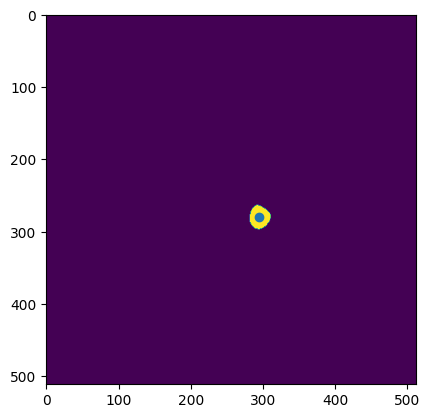

In [11]:
# Compute center from carthesian model prediction
center = centroid(carthesian_model_prediction.astype(np.uint8))
plt.imshow(carthesian_model_prediction)
plt.scatter(*center)

In [12]:
# Prepare input for inference on polar model
polar_input = np.expand_dims(np.expand_dims(to_polar(postprocessed_slice, center), 0), 0).astype(np.float32)

# Compute output of the polar model
polar_out = polar_inference_session.run(None, {"input": polar_input})[0]
polar_model_prediction = np.argmax(polar_out, axis=1)[0]

# Convert prediction of polar model to carthesian coordinates
polar_output_cart = to_cart(polar_model_prediction, center)

print(polar_output_cart.shape)
print(np.unique(polar_output_cart))

(512, 512)
[0 1]


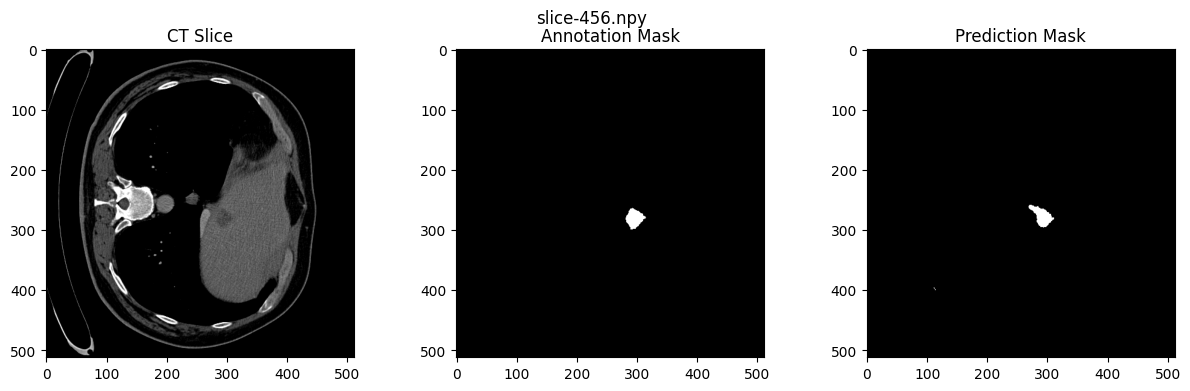

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].imshow(postprocessed_slice, cmap="gray")
axs[0].set_title("CT Slice")
axs[1].imshow(valid_mask_data, cmap="gray")
axs[1].set_title("Annotation Mask")
axs[2].imshow(polar_output_cart, cmap="gray")
axs[2].set_title("Prediction Mask")

_ = fig.suptitle(valid_mask_name)

# Prediction Comparison: Carthesian vs Polar

In [14]:
def plot_mask_vs_prediction(scan_slice, mask, prediction, title):
    multi_channel_slice = np.stack(3 * [scan_slice], axis=2)

    # true positive predictions = green
    intersection = mask * prediction
    multi_channel_slice[np.nonzero(intersection)] = (0.0, 1.0, 0.0)
    
    # false positive predictions = red
    multi_channel_slice[np.nonzero((mask == 0) * (prediction == 1))] = (1.0, 0.0, 0.0)

    # false negative prediction = blue
    multi_channel_slice[np.nonzero((mask == 1) * (prediction == 0))] = (0.0, 0.0, 1.0)

    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    green_patch = mpatches.Patch(color="lawngreen", label="True Positives")
    red_patch = mpatches.Patch(color="red", label="False Positives")
    blue_patch = mpatches.Patch(color="blue", label="False Negatives")
    plt.legend(handles=[green_patch, red_patch, blue_patch])
    axs[0].imshow(scan_slice, cmap="gray")
    axs[1].imshow(multi_channel_slice)
    plt.suptitle(title)

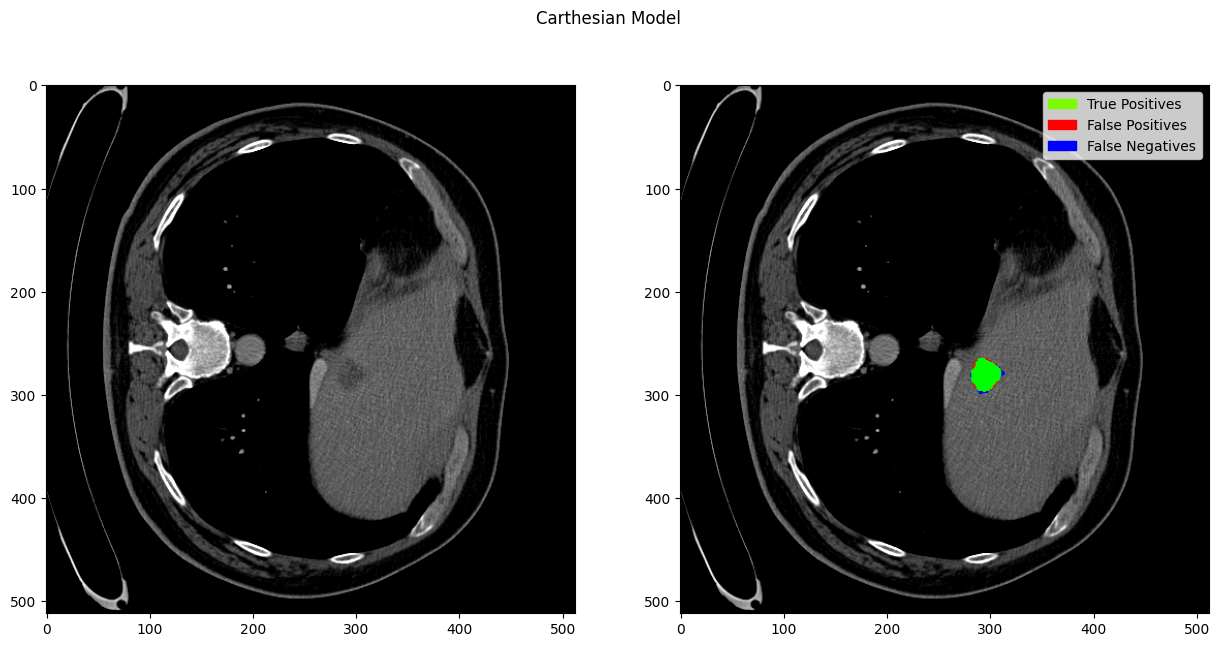

In [15]:
plot_mask_vs_prediction(postprocessed_slice, valid_mask_data, carthesian_model_prediction, "Carthesian Model")

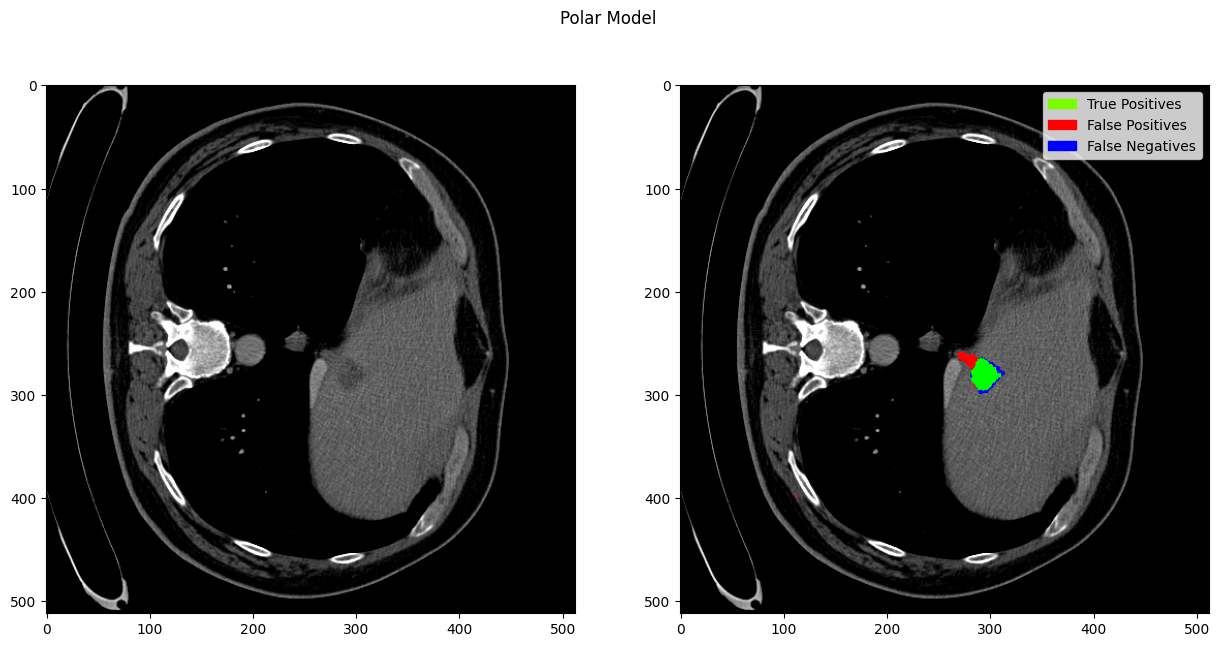

In [18]:
plot_mask_vs_prediction(postprocessed_slice, valid_mask_data, polar_output_cart, "Polar Model")